In [14]:
# Bu hücrede eğitim/test veri setlerini CSV'den yüklüyorum.
# X_train, X_test, y_train ve y_test boyutlarını kontrol ediyorum.
# Ayrıca ilk sütunların doğru geldiğini görmek için X_train.head() ile bakıyorum.

In [15]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train = pd.read_csv("X_train_final_KUSURSUZ.csv")
X_test = pd.read_csv("X_test_final_KUSURSUZ.csv")

y_train = pd.read_csv("y_train_encoded_final_KUSURSUZ.csv")["Kingdom_Encoded"]
y_test  = pd.read_csv("y_test_encoded_final_KUSURSUZ.csv")["Kingdom_Encoded"]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

X_train.head()


X_train: (10422, 66)
X_test : (2606, 66)
y_train: (10422,)
y_test : (2606,)


,DNAtype,Ncodons,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,0.910093,-0.062642,5.058891,-1.610835,1.659643,7.393991,-1.353206,-1.144576,-0.671603,-0.891852,...,-0.371385,0.161263,1.536117,-0.420016,-1.597336,-1.438210,-0.343836,0.338408,1.120308,0.273677
1,-0.531395,-0.110931,-0.892977,1.342811,-0.815257,-0.330819,-1.123895,-0.415093,-0.524157,1.486119,...,0.567714,-0.906231,-0.646929,0.953082,0.926270,-0.382764,1.789139,-0.311003,-0.336485,-0.554030
2,2.351581,-0.126515,2.272050,-0.161035,1.181751,0.806385,0.918019,-1.121972,-0.220152,-0.401169,...,-0.529915,0.912854,-0.387526,0.239822,-1.176479,0.762611,-1.050167,-0.920884,1.549440,-0.601689
3,0.910093,-0.126496,-0.087624,-0.097553,-0.246131,-0.261962,0.798131,2.530919,2.705995,-0.349868,...,-0.532935,-1.159893,-1.000091,-1.601804,-1.330357,-1.227679,-1.247887,1.270170,0.431436,1.285210
4,-0.531395,-0.120793,0.769559,-1.189621,0.095151,2.314767,-0.369358,-0.865797,-0.552735,-0.656469,...,-0.172091,0.099022,0.282858,1.996984,-0.557888,-0.571685,0.426405,-0.147238,0.103940,-0.535551


In [16]:
#bu hücrede DNA kodon frekanslarını içeren sütunları belirliyorum.
#ilk iki sütun 'DNAtype' ve 'Ncodons' olduğu için bunları dışarıda bırakıp geri kalan tüm sütunları kodon değişkeni olarak seçiyorum.
#kodonların doğru alındığını teyit etmek için hem toplam sayıyı yazdırıyorum hem de ilk birkaç kodon ismini görüntülüyorum.
#bu adım daha sonra RSCU ve CAI hesaplamalarında hangi özelliklerin kullanılacağını belirlediği için önemlidir.

In [17]:
# Kodon sütunları (DNAtype ve Ncodons hariç)
codon_cols = X_train.columns[2:]

print("Kodon sayısı:", len(codon_cols))
print(codon_cols[:10])


Kodon sayısı: 64
Index(['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC'], dtype='object')


In [18]:
# aa_table sözlüğü, her kodonun (UUU, GGA, ACG gibi 3’lü nükleotid dizileri)
#hangi aminoaside karşılık geldiğini gösteren bir genetik kod tablosudur.
#bu tablo biyoinformatik hesaplamalarda çok kritiktir çünkü:
# 1) Aynı aminoasidi kodlayan eş anlamlı kodonların gruplanmasını sağlar.
# 2) RSCU hesaplamasında her aminoasit için kullanılan tüm kodonlar önce bu tablo ile belirlenir.
# 3) CAI hesaplamasında kodon tercih indeksleri (w_i) hesaplanırken yine bu tablo kullanılır.
#örneğin:
#   - 'UUU' → 'F' (Fenilalanin)
#   - 'CUG' → 'L' (Lösin)
#   - 'AUG' → 'M' (Metiyonin, ayrıca start kodonu)
#   - 'UAA', 'UAG', 'UGA' → '*' (Stop kodonları)
#sonuç olarak aa_table, RSCU ve CAI hesaplamalarının temelini oluşturan
#“kodon → aminoasit” eşleştirme tablosudur.

In [19]:
aa_table = {
    'UUU':'F','UUC':'F','UUA':'L','UUG':'L','CUU':'L','CUC':'L','CUA':'L','CUG':'L',
    'AUU':'I','AUC':'I','AUA':'I','AUG':'M','GUU':'V','GUC':'V','GUA':'V','GUG':'V',
    'GCU':'A','GCC':'A','GCA':'A','GCG':'A','CCU':'P','CCC':'P','CCA':'P','CCG':'P',
    'UGG':'W','GGU':'G','GGC':'G','GGA':'G','GGG':'G','UCU':'S','UCC':'S','UCA':'S',
    'UCG':'S','AGU':'S','AGC':'S','ACU':'T','ACC':'T','ACA':'T','ACG':'T',
    'UAU':'Y','UAC':'Y','CAA':'Q','CAG':'Q','AAU':'N','AAC':'N','UGU':'C','UGC':'C',
    'CAU':'H','CAC':'H','AAA':'K','AAG':'K','CGU':'R','CGC':'R','CGA':'R','CGG':'R',
    'AGA':'R','AGG':'R','GAU':'D','GAC':'D','GAA':'E','GAG':'E',
    'UAA':'*','UAG':'*','UGA':'*'
}


In [20]:
#bu hücrede RSCU (Relative Synonymous Codon Usage) değerlerini hesaplayan fonksiyonu yazıyorum.
#RSCU, her aminoasit için eş anlamlı kodonların kullanım oranlarını normalize eden önemli bir biyoinformatik metriktir.
#ilk olarak aminoasit → kodon eşleşmesini oluşturuyorum (aa_to_codons).
#daha sonra her aminoasit için kodonların toplam kullanımını hesaplıyorum ve her kodon için RSCU değerini şu şekilde hesaplıyorum:
#RSCU = (kodon kullanım sayısı / o aminoasitteki tüm kodonların toplamı) * (eş anlamlı kodon sayısı)
#böylece bir kodonun "beklenen ortalamaya göre ne kadar fazla" kullanıldığını öğrenmiş oluyorum.
#sonuç olarak dataset'e her kodon için 'RSCU_XXX' şeklinde yeni sütunlar ekleniyor.

In [21]:
import numpy as np

def compute_rscu(df, codon_cols, aa_table):
    df_rscu = df.copy()

    # Aminoasit -> Kodon listesi oluştur
    aa_to_codons = {}
    for codon, aa in aa_table.items():
        if aa == "*":  # stop codon atlama
            continue
        aa_to_codons.setdefault(aa, []).append(codon)

    # her aminoasit için RSCU hesapla
    for aa, codons in aa_to_codons.items():
        valid = [c for c in codons if c in df_rscu.columns]
        if not valid:
            continue

        total = df_rscu[valid].sum(axis=1)

        for c in valid:
            df_rscu[f"RSCU_{c}"] = np.where(total > 0,
                                            df_rscu[c] * len(valid) / total,
                                            0)
    return df_rscu


In [22]:
#bu hücrede bir önceki hücrede yazdığım RSCU hesaplama fonksiyonunu hem eğitim hem test seti üzerinde uyguluyorum.
#amaç, her satırdaki kodon kullanımını biyolojik olarak normalize edilmiş bir forma dönüştürmek.
#RSCU, CAI hesaplamasının temelini oluşturur ve biyolojik anlamı güçlü bir özelliktir.
#kaç tane RSCU sütunu oluştuğunu hesaplayarak fonksiyonun doğru çalıştığını doğruluyorum.

In [23]:
X_train_rscu = compute_rscu(X_train, codon_cols, aa_table)
X_test_rscu  = compute_rscu(X_test, codon_cols, aa_table)

print("RSCU sütunları:", len([c for c in X_train_rscu.columns if c.startswith("RSCU_")]))
X_train_rscu.head()


RSCU sütunları: 61


,DNAtype,Ncodons,UUU,UUC,UUA,UUG,CUU,CUC,CUA,CUG,...,RSCU_CGU,RSCU_CGC,RSCU_CGA,RSCU_CGG,RSCU_AGA,RSCU_AGG,RSCU_GAU,RSCU_GAC,RSCU_GAA,RSCU_GAG
0,0.910093,-0.062642,5.058891,-1.610835,1.659643,7.393991,-1.353206,-1.144576,-0.671603,-0.891852,...,10.368893,-6.933701,-7.966921,-2.949732,1.280835,12.200626,0.000000,0.000000,0.000000,0.000000
1,-0.531395,-0.110931,-0.892977,1.342811,-0.815257,-0.330819,-1.123895,-0.415093,-0.524157,1.486119,...,3.546288,9.742045,5.574424,7.410225,-11.828793,-8.444189,1.014267,0.985733,-0.544328,2.544328
2,2.351581,-0.126515,2.272050,-0.161035,1.181751,0.806385,0.918019,-1.121972,-0.220152,-0.401169,...,3.886830,-3.881557,6.014363,-2.268690,3.908143,-1.659089,0.000000,0.000000,0.000000,0.000000
3,0.910093,-0.126496,-0.087624,-0.097553,-0.246131,-0.261962,0.798131,2.530919,2.705995,-0.349868,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.531395,-0.120793,0.769559,-1.189621,0.095151,2.314767,-0.369358,-0.865797,-0.552735,-0.656469,...,8.078232,-1.420103,-1.558985,-0.738974,0.425210,1.214620,2.775331,-0.775331,0.000000,0.000000


In [24]:
#bu hücrede CAI hesaplamak için gerekli olan w_i ağırlıklarını çıkarıyorum.
#CAI, bir genin yüksek ifade seviyeli referans genlere ne kadar benzediğini ölçen bir metriktir.
#önce tüm RSCU sütunlarının train setindeki ortalamasını alarak "referans RSCU profili" oluşturuyorum.
#ardından her kodon için:
#   w_i = RSCU_i / (aynı aminoasitin en yüksek RSCU değerine sahip kodonu)
# formülünü kullanıp ağırlıkları hesaplıyorum.
#bu ağırlıklar 0–1 arasında olup bir kodonun "tercihlilik düzeyini" gösterir.

In [25]:
# TRAIN içindeki tüm RSCU sütunlarının ortalaması → referans tablo
rscu_cols = [c for c in X_train_rscu.columns if c.startswith("RSCU_")]
train_ref = X_train_rscu[rscu_cols].mean()

# w_i ağırlıkları hesapla (her kodon için)
w = {}
for col in rscu_cols:
    aa = col.split("_")[1]
    aa_codons = [f"RSCU_{c}" for c,a in aa_table.items() if a == aa]

    vals = train_ref[aa_codons]
    maxv = vals.max()

    w[col] = (train_ref[col] / maxv) if maxv > 0 else 1.0

w_list = list(w.items())[:10]
w_list


[('RSCU_UUU', 1.0),
 ('RSCU_UUC', 1.0),
 ('RSCU_UUA', 1.0),
 ('RSCU_UUG', 1.0),
 ('RSCU_CUU', 1.0),
 ('RSCU_CUC', 1.0),
 ('RSCU_CUA', 1.0),
 ('RSCU_CUG', 1.0),
 ('RSCU_AUU', 1.0),
 ('RSCU_AUC', 1.0)]

In [26]:
#bu hücrede CAI (Codon Adaptation Index) skorunu hesaplayan fonksiyonu tanımlıyorum.
#her satırdaki (yani her örnekteki) tüm kodonların ağırlıklarını alıyorum.
#CAI hesaplaması logaritmik ortalama ile yapılır çünkü:
#   - çarpımsal bir etkiye sahiptir
#   - kodonlardan biri çok küçük bir değere sahipse tüm diziyi etkiler
#bu nedenle log ortalama kullanıp tekrar üstel fonksiyonla geri dönüş yapıyorum.
#CAI tek bir sayı olup ilgili dizinin yüksek ifade seviyeli referans dizilere benzerliğini ölçer.
#bu nedenle CAI değeri makine öğrenmesi için güçlü bir ek özellik sunar.

In [27]:
def compute_cai(df, w, codon_cols):
    cai_list = []
    for idx, row in df.iterrows():
        weights = []
        for c in codon_cols:
            col = f"RSCU_{c}"
            if col in df.columns:
                weights.append(w[col] + 1e-9)
        cai = np.exp(np.mean(np.log(weights)))
        cai_list.append(cai)

    df = df.copy()
    df["CAI"] = cai_list
    return df


In [28]:
#bu hücrede CAI fonksiyonunu hem eğitim hem test setlerine uyguluyorum.
#böylece her örnek (organizma/sekans) için tek bir 'CAI' değeri eklenmiş oluyor.
#CAI'nın hesaplandığını ve veri setine başarıyla eklendiğini kontrol etmek için ilk birkaç değeri görüntülüyorum.

In [29]:
X_train_fe = compute_cai(X_train_rscu, w, codon_cols)
X_test_fe  = compute_cai(X_test_rscu,  w, codon_cols)

print("CAI eklendi.")
X_train_fe[["CAI"]].head()


CAI eklendi.


,CAI
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [30]:
#bu hücrede Feature Engineering uygulanmış verilerle SVM modelini eğitiyorum.
#ilk olarak StandardScaler ile veriyi ölçekliyorum çünkü SVM özellikle lineer kernelde ölçeksiz veriden olumsuz etkilenebilir.
#daha sonra kernel='linear' seçerek basit ama güçlü bir sınıflandırıcı kuruyorum.
#ardından test seti üzerinde tahmin yapıp Accuracy, F1-micro ve ROC AUC skorlarını hesaplıyorum.
#ROC AUC çok sınıflı problem olduğu için 'ovr' (one-vs-rest) stratejisiyle hesaplanıyor.
#bu hücre, FE'nin modele katkısının temel performans ölçümlerini gösteriyor.

In [31]:
#1) FE → SVM (FS YOK)

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# SCALE
scaler1 = StandardScaler()
X_train_fe_scaled = scaler1.fit_transform(X_train_fe)
X_test_fe_scaled  = scaler1.transform(X_test_fe)

# SVM
svm_fe = SVC(kernel="linear", probability=True, random_state=42)
svm_fe.fit(X_train_fe_scaled, y_train)

# Tahmin
y_pred_fe = svm_fe.predict(X_test_fe_scaled)
y_score_fe = svm_fe.predict_proba(X_test_fe_scaled)

# ROC için y_test'i binarize etme
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# SONUÇLAR
acc_fe = accuracy_score(y_test, y_pred_fe)
f1_fe_micro = f1_score(y_test, y_pred_fe, average="micro")
roc_fe_micro = roc_auc_score(y_test_bin, y_score_fe, average="micro", multi_class="ovr")

print("=== FE → SVM ===")
print("Accuracy :", acc_fe)
print("F1 Micro :", f1_fe_micro)
print("ROC AUC Micro :", roc_fe_micro)


=== FE → SVM ===
Accuracy : 0.885264773599386
F1 Micro : 0.885264773599386
ROC AUC Micro : 0.9906047588391862


In [32]:
#bu hücrede FE → SVM modeli için hem train hem de test veri setlerine ait confusion matrixlerini çiziyorum.

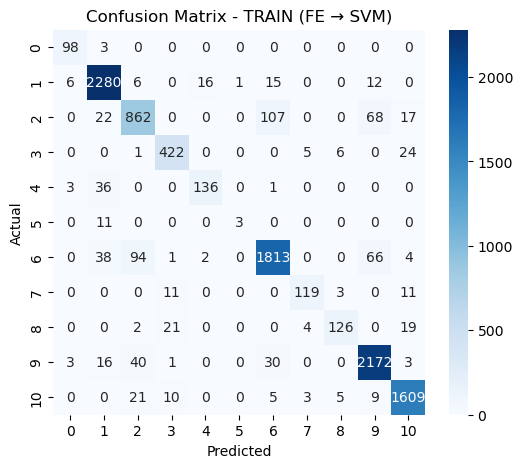

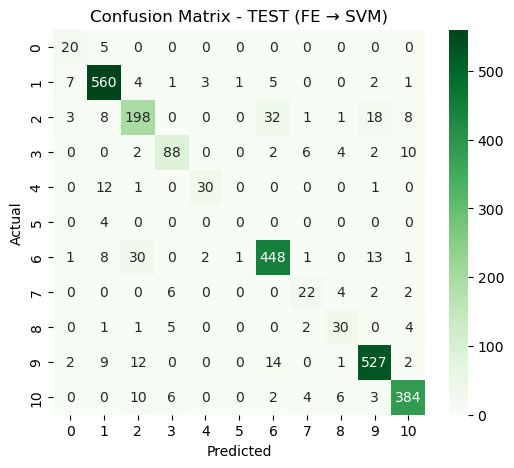

In [33]:
#Confusion Matrix (TRAIN | FE → SVM)
y_train_pred_fe = svm_fe.predict(X_train_fe_scaled)

cm_train_fe = confusion_matrix(y_train, y_train_pred_fe)
plt.figure(figsize=(6,5))
sns.heatmap(cm_train_fe, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - TRAIN (FE → SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Confusion Matrix (TEST | FE → SVM)
cm_test_fe = confusion_matrix(y_test, y_pred_fe)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test_fe, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - TEST (FE → SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [34]:
#bu hücrede Feature Engineering (FE) uygulanmış veriler üzerinde PCA
#yöntemi ile boyut indirgeme yapıp, ardından bu yeni düşük boyutlu bileşenlerle SVM sınıflandırma modeli
#eğitiyorum. Bu süreçte amaç, yüksek boyutlu veri setindeki gürültüyü azaltmak, önemli varyansı koruyarak
#daha sade ve daha verimli bir temsil oluşturmaktır.
#
# 1)Scaling:
#PCA uygulamadan önce veriyi StandardScaler ile ölçekliyorum. Çünkü PCA varyansa duyarlı bir yöntemdir;
#yani bazı özellikler büyük sayısal aralığa sahipse PCA bileşenlerini yanlış yönlendirebilir. Bu nedenle
#her özelliğin ortalamasını 0, standart sapmasını 1 olacak şekilde normalize etmek zorunludur.
#
# 2)PCA(Boyut indirgeme):
#n_components=0.95 parametresi ile toplam varyansın %95’ini koruyacak kadar PCA bileşeni seçiyorum.
#Bu, PCA’nın otomatik olarak uygun bileşen sayısını hesaplayıp veri kaybı olmadan boyut indirgeme yaptığı
#anlamına gelir. PCA hem hesaplama maliyetini azaltır hem de modelin gürültüye karşı daha dayanıklı olmasını sağlar.
#
# 3)SVM(Model Eğitimi):
#PCA sonrası elde edilen yeni özelliklerle (ana bileşenlerle) SVM modelini eğitiyorum.
#Kernel olarak "linear" seçiyorum çünkü PCA zaten veriyi doğrusal olarak ayrılabilir bir uzaya taşıyabilir.
#Model eğitildikten sonra test verisi üzerinde tahmin yapıyorum.
#
#Ardından Accuracy, F1-Micro ve ROC-AUC metriklerini hesaplıyorum.
#ROC-AUC çok sınıflı yapıda olduğu için y_test değerlerini binarize ederek değerlendiriyorum.
#
#Bu hücre genel olarak FE → PCA → SVM aşamasının tamamını içerir ve PCA’nın model performansına
#nasıl etkilediğini değerlendirmek için gereken tüm metrikleri hesaplar.


In [35]:
# FE → PCA → SVM

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# 1) Scaling (mandatory)
scaler_pca = StandardScaler()
X_train_scaled = scaler_pca.fit_transform(X_train_fe)
X_test_scaled  = scaler_pca.transform(X_test_fe)

# 2) PCA
# Varyansın %95'ini koruyacak kadar bileşen seçsin
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("PCA sonrası yeni özellik sayısı:", X_train_pca.shape[1])

# 3) SVM
svm_pca = SVC(kernel="linear", probability=True, random_state=42)
svm_pca.fit(X_train_pca, y_train)

# Tahminler
y_pred_pca = svm_pca.predict(X_test_pca)
y_score_pca = svm_pca.predict_proba(X_test_pca)

# ROC-AUC için binarize
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)

# Skorlar
acc_pca = accuracy_score(y_test, y_pred_pca)
f1_pca_micro = f1_score(y_test, y_pred_pca, average="micro")
roc_pca_micro = roc_auc_score(y_test_bin, y_score_pca, average="micro", multi_class="ovr")

print("=== FE → PCA → SVM ===")
print("Accuracy :", acc_pca)
print("F1 Micro :", f1_pca_micro)
print("ROC AUC Micro :", roc_pca_micro)


PCA sonrası yeni özellik sayısı: 69
=== FE → PCA → SVM ===
Accuracy : 0.8595548733691482
F1 Micro : 0.8595548733691482
ROC AUC Micro : 0.9872143303516473


In [36]:
#bu hücrede FE → PCA → SVM modeli için hem eğitim (train) hem de test veri setlerine ait confusion matrixlerini çiziyorum.

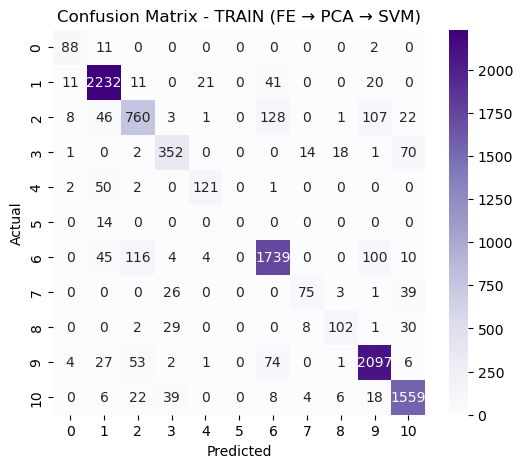

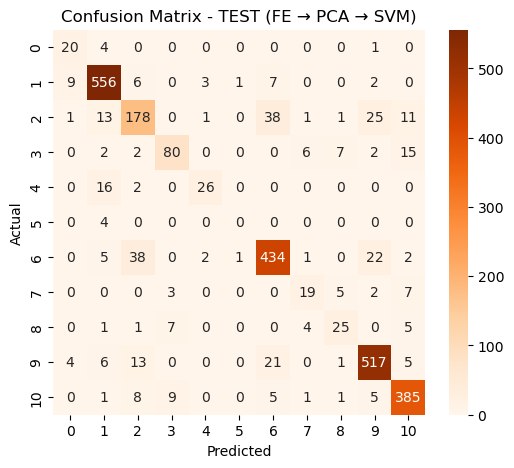

In [37]:
#Confusion Matrix (TRAIN | FE → PCA → SVM)
y_train_pred_pca = svm_pca.predict(X_train_pca)

cm_train_pca = confusion_matrix(y_train, y_train_pred_pca)
plt.figure(figsize=(6,5))
sns.heatmap(cm_train_pca, annot=True, fmt="d", cmap="Purples")
plt.title("Confusion Matrix - TRAIN (FE → PCA → SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Confusion Matrix (TEST | FE → PCA → SVM)
cm_test_pca = confusion_matrix(y_test, y_pred_pca)
plt.figure(figsize=(6,5))
sns.heatmap(cm_test_pca, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - TEST (FE → PCA → SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [38]:
#bu hücrede FE → PCA → SVM modelinin test karışıklık matrisini daha büyük ve daha anlaşılır şekilde çiziyorum.
#grafik başlığına doğruluk skorunu ekleyerek görsel bir özet sunuyorum.

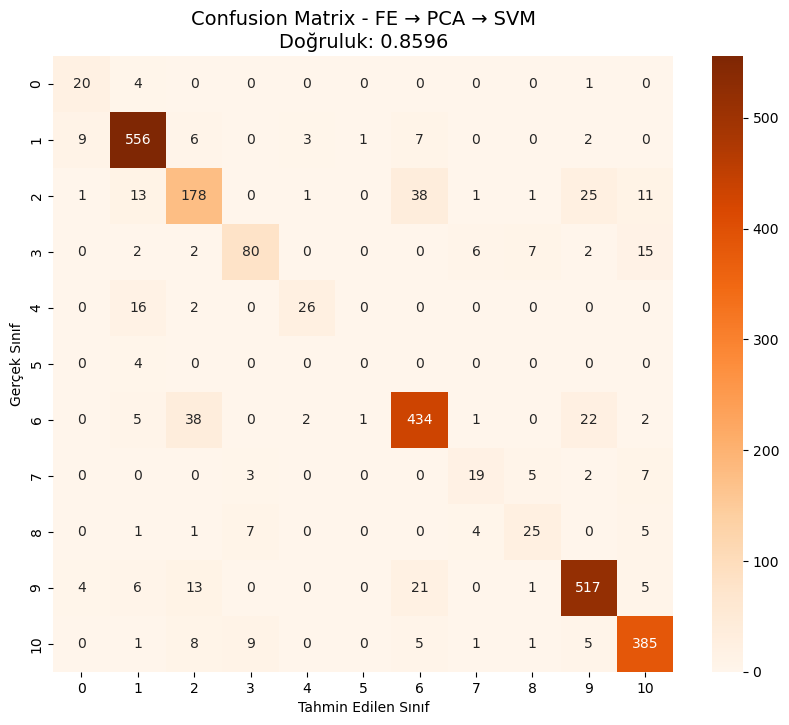

In [39]:
# CONFUSION MATRIX - FE → PCA → SVM
cm_pca = confusion_matrix(y_test, y_pred_pca)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_pca, annot=True, fmt="d", cmap="Oranges")
plt.title(f"Confusion Matrix - FE → PCA → SVM\nDoğruluk: {acc_pca:.4f}", fontsize=14)
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()


In [40]:
#bu hücrede iki modelin (FE → SVM ve FE → PCA → SVM) tüm performans metriklerini tek bir DataFrame'de topluyorum.
#bu tablo modelleri karşılaştırmak için net ve anlaşılır bir özet sunuyor.
#Accuracy, F1-score ve ROC AUC gibi metrikler sayesinde hangi modelin daha iyi olduğunu kolayca görebiliyoruz.

In [41]:
import pandas as pd

results_pca = pd.DataFrame({
    "Model": ["FE → SVM", "FE → PCA → SVM"],
    "Accuracy": [acc_fe, acc_pca],
    "F1 Micro": [f1_fe_micro, f1_pca_micro],
    "ROC AUC Micro": [roc_fe_micro, roc_pca_micro]
})

results_pca


,Model,Accuracy,F1 Micro,ROC AUC Micro
0,FE → SVM,0.885265,0.885265,0.990605
1,FE → PCA → SVM,0.859555,0.859555,0.987214
